**QOSF Mentorship Screening task - Task 3 - Zero Noise extrapoliation**

Zero-noise extrapolation (ZNE) is a noise mitigation technique. It works by intentionally scaling
the noise of a quantum circuit to then extrapolate the zero-noise limit of an observable of
interest. In this task, you will build a simple ZNE function from scratch:

1.   Build a simple noise model with depolarizing noise
2.   Create different circuits to test your noise models and choose the observable to measure
3.   Apply the unitary folding method.
4.   Apply the extrapolation method to get the zero-noise limit. Different extrapolation methods achieve different results, such as Linear, polynomial, and exponential.
5.   Compare mitigated and unmitigated results
6.   Bonus: Run your ZNE function in real quantum hardware through the IBM Quantum Service.


Check the Mitiq documentation for references. You are not allowed to use the functions from
Mitiq or any other frameworks where ZNE is already implemented.

In [1]:
!pip install qiskit

In [2]:
!pip install pylatexenc
!pip install qiskit-aer
!pip install qiskit-aer-noise

ERROR: Could not find a version that satisfies the requirement qiskit-aer-noise (from versions: none)
ERROR: No matching distribution found for qiskit-aer-noise


**Outline**


1.   Section 1 - Building a simple circuit with depolarizing noise (5%) and testing ZNE.
2.   Section 2 - Testing out with various extrapolations tecnhiques.
3.   Section 3 - Testing the ZNE process for a circuit with huge depolarization error of 50%
4.   Section 4 - Tesing with a circuit of huge depth (depth 5 X gates).
5.   Section 5 - Tesing ZNE implementation with multiple qubits (5 qubits GHz state).



In [3]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import *

**Section 1 - Building a simple circuit with depolarizing noise**

The circuit acts on a single qubit and performs X operation on it.

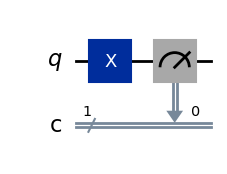

In [4]:
circuit = QuantumCircuit(1,1)
circuit.x(0)
circuit.measure(0,0)
circuit.draw('mpl')

Noiseless simulation

In [5]:
# from qiskit.primitives.sampler import Sampler
# sampler = Sampler()
# job = sampler.run(circuit, shots=1000)
# result = job.result()
# print(f" > Quasi probability distribution: {result.quasi_dists}")

{'1': 1024}


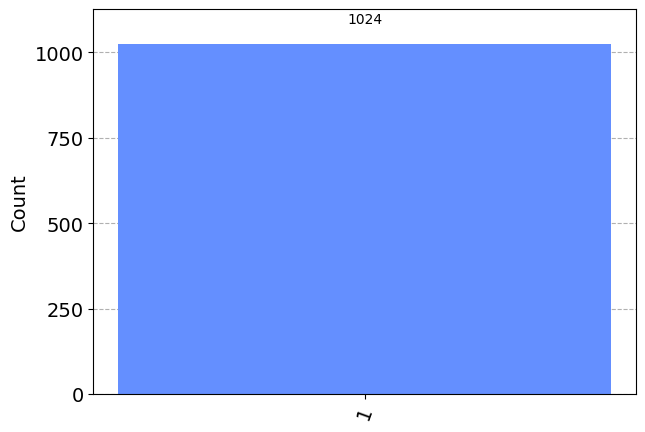

In [6]:
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
sim_ideal = AerSimulator()

# Execute and get counts
result = sim_ideal.run(transpile(circuit, sim_ideal),shots=1024).result()
counts = result.get_counts(0)
print(counts)
plot_histogram(counts)

Adding a depolarising noise model

Depolarising error of 5% on all qubits.

In [7]:
from qiskit_aer.noise import (NoiseModel, depolarizing_error)
# Create an empty noise model
noise_model = NoiseModel()

# Add depolarizing error to all single qubit u1, u2, u3 gates
error = depolarizing_error(0.05, 1)
noise_model.add_all_qubit_quantum_error(error, ['u1', 'u2', 'u3'])

# Print noise model info
print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['u2', 'u1', 'u3']
  All-qubits errors: ['u1', 'u2', 'u3']


Noisy simulation

{'0': 20, '1': 1004}


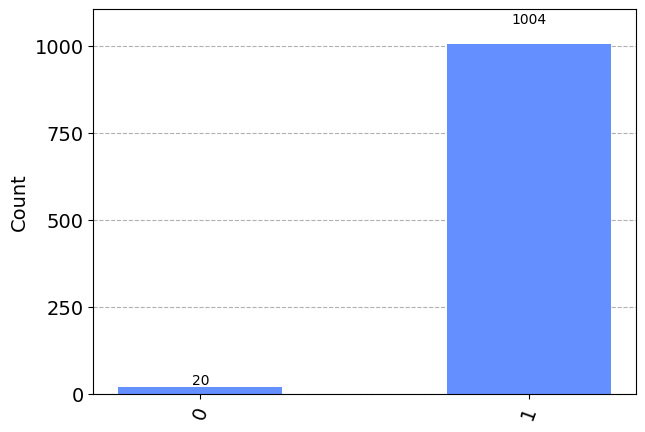

In [8]:
sim_noisy = AerSimulator(noise_model=noise_model)

# Execute and get counts
result = sim_noisy.run(transpile(circuit, sim_noisy),shots=1024).result()
counts = result.get_counts(0)
print(counts)
plot_histogram(counts)

We perform folding of the circuit from 1 fold to 15 fold in steps of 2 so as to have odd number of X gates to maintain the desired output of |1>.

In [9]:
from tqdm import tqdm
arr = []
noise_scale_factor = []
# We performing folding by repeating the circuit odd number of times
# to preseve the output.
for x in tqdm(range(1,16,2)):
  noise_scale_factor.append(x)
  circuit = QuantumCircuit(1,1)
  for i in range(x):
    circuit.x(0)
  circuit.measure(0,0)

  noise_model = NoiseModel()
  error = depolarizing_error(0.05, 1)
  noise_model.add_all_qubit_quantum_error(error, ['u1', 'u2', 'u3'])

  sim_noisy = AerSimulator(noise_model=noise_model)

  # Execute and get counts
  result = sim_noisy.run(transpile(circuit, sim_noisy),shots=1024).result()
  counts = result.get_counts(0)
  arr.append(counts.get('1')/1024)

100%|██████████| 8/8 [00:00<00:00, 23.41it/s]


A plot of the probabilites for each level of noise scaling is shown below.

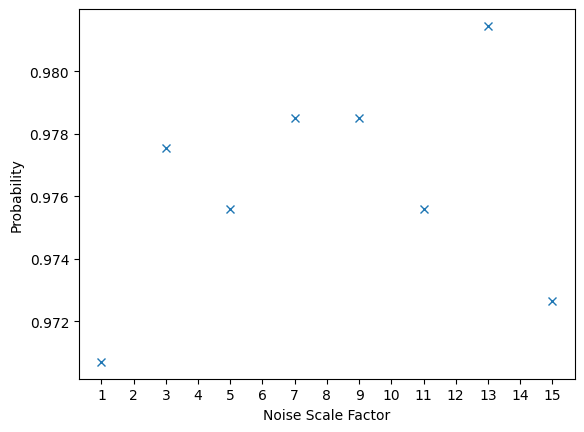

In [10]:
import matplotlib.pyplot as plt
plt.xticks(range(min(noise_scale_factor), max(noise_scale_factor)+1))
plt.plot(noise_scale_factor,arr,'x')
plt.xlabel('Noise Scale Factor')
plt.ylabel('Probability')
plt.show()

**Section 2 - Performing Extrapolation using various techniques**

We start with Linear extrapolation technique

In [11]:
from scipy import interpolate
x = np.array(noise_scale_factor)
y = np.array(arr)
order = 1 # Linear
s = interpolate.interp1d(x, y,kind="linear",fill_value="extrapolate")
value_without_error = s(0)
print(value_without_error)

0.96728515625


Using Numpy Polyfit functions

In [12]:
import numpy as np
p = np.polyfit(x,y,deg=1)
x_new = np.array([0])
y_new = np.polyval(p,x_new)
print(y_new)

[0.97473726]


Testing out with Polynomial extrapolation starting from degree 2 to degree 5

In [13]:
for i in range(2,6):
  p = np.polyfit(x,y,deg=i)
  x_new = np.array([0])
  y_new = np.polyval(p,x_new)
  print("degree:",str(i),"-",str(y_new))

degree: 2 - [0.96986316]
degree: 3 - [0.97026267]
degree: 4 - [0.96340171]
degree: 5 - [0.96822785]


Tesing out with exponential extrapolation

In [14]:
p = np.polyfit(np.log(x),y,deg=1)
x_new = np.array([0])
y_new = np.polyval(p,x_new)
print(y_new)

[0.97290472]


Plot of linear extrapolated results using various noise scaling.

The unmitigated results are represented in dots and the totally mitigated results in expressed in x

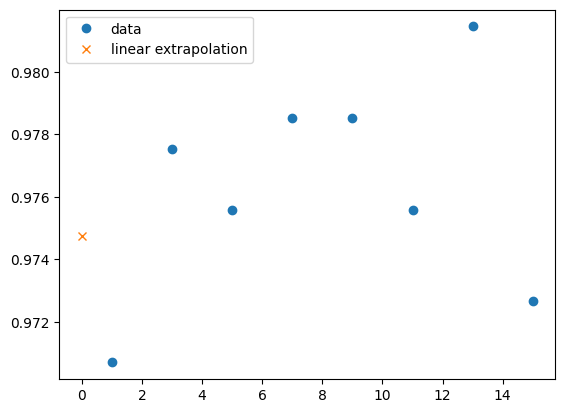

In [15]:
p = np.polyfit(x,y,deg=1)
x_new = np.array([0])
y_new = np.polyval(p,x_new)

plt.plot(x,y, 'o', label='data')
plt.plot(x_new, y_new, 'x', label='linear extrapolation')
plt.legend()
plt.show()

**Section 3 - Testing the ZNE process for a circuit with huge deploarization error of 50%**

In [16]:
from tqdm import tqdm
arr = []
noise_scale_factor = []
# We performing folding by repeating the circuit odd number of times
# to preseve the output.
for x in tqdm(range(1,16,2)):
  noise_scale_factor.append(x)
  circuit = QuantumCircuit(1,1)
  for i in range(x):
    circuit.x(0)
  circuit.measure(0,0)

  noise_model = NoiseModel()
  error = depolarizing_error(0.5, 1)
  noise_model.add_all_qubit_quantum_error(error, ['u1', 'u2', 'u3'])

  sim_noisy = AerSimulator(noise_model=noise_model)

  # Execute and get counts
  result = sim_noisy.run(transpile(circuit, sim_noisy),shots=1024).result()
  counts = result.get_counts(0)
  arr.append(counts.get('1')/1024)


x = np.array(noise_scale_factor)
y = np.array(arr)

for i in range(1,6):
  p = np.polyfit(x,y,deg=i)
  x_new = np.array([0])
  y_new = np.polyval(p,x_new)
  print("degree:",str(i),"-",str(y_new))

100%|██████████| 8/8 [00:00<00:00, 33.63it/s]

degree: 1 - [0.73740932]
degree: 2 - [0.7429083]
degree: 3 - [0.73891327]
degree: 4 - [0.74189066]
degree: 5 - [0.77418866]


Taking the best probability and plotting - degree 5 gives higer probability

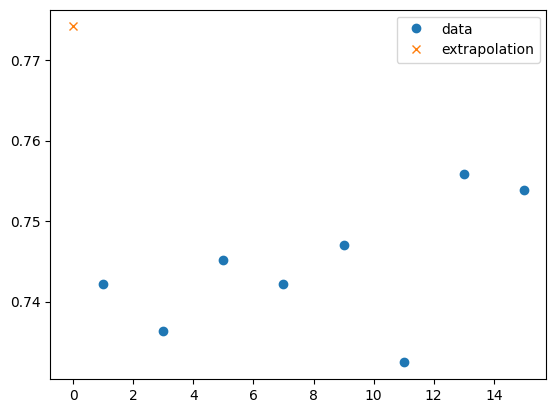

In [17]:
p = np.polyfit(x,y,deg=5)
x_new = np.array([0])
y_new = np.polyval(p,x_new)

plt.plot(x,y, 'o', label='data')
plt.plot(x_new, y_new, 'x', label='extrapolation')
plt.legend()
plt.show()

**Section 4 - Tesing the ZNE with a circuit of huge depth**

The circuit to be computed has a set of 5 X gates acting on one qubit in this case. The depolarizing error for a single gate is 5%.

In [18]:
from tqdm import tqdm
arr = []
noise_scale_factor = []
# We performing folding by repeating the circuit odd number of times
# to preseve the output.
for x in tqdm(range(1,16,2)):
  noise_scale_factor.append(x)
  circuit = QuantumCircuit(1,1)
  for i in range(5*x):
    circuit.x(0)
  circuit.measure(0,0)

  noise_model = NoiseModel()
  error = depolarizing_error(0.05, 1)
  noise_model.add_all_qubit_quantum_error(error, ['u1', 'u2', 'u3'])

  sim_noisy = AerSimulator(noise_model=noise_model)

  # Execute and get counts
  result = sim_noisy.run(transpile(circuit, sim_noisy),shots=1024).result()
  counts = result.get_counts(0)
  arr.append(counts.get('1')/1024)


x = np.array(noise_scale_factor)
y = np.array(arr)

for i in range(1,6):
  p = np.polyfit(x,y,deg=i)
  x_new = np.array([0])
  y_new = np.polyval(p,x_new)
  print("degree:",str(i),"-",str(y_new))

100%|██████████| 8/8 [00:00<00:00, 33.65it/s]

degree: 1 - [0.9732201]
degree: 2 - [0.97478231]
degree: 3 - [0.97817808]
degree: 4 - [0.98704554]
degree: 5 - [0.98351875]


Plotting the one with maximum probability - degree 4

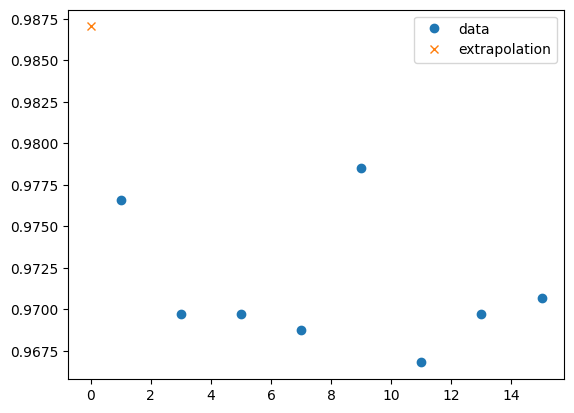

In [19]:
p = np.polyfit(x,y,deg=4)
x_new = np.array([0])
y_new = np.polyval(p,x_new)

plt.plot(x,y, 'o', label='data')
plt.plot(x_new, y_new, 'x', label='extrapolation')
plt.legend()
plt.show()

**Section 5 - Tesing the ZNE implementation with multiple qubits (GHZ state in 5 qubits)**

We prepare a 5 qubit GHz state

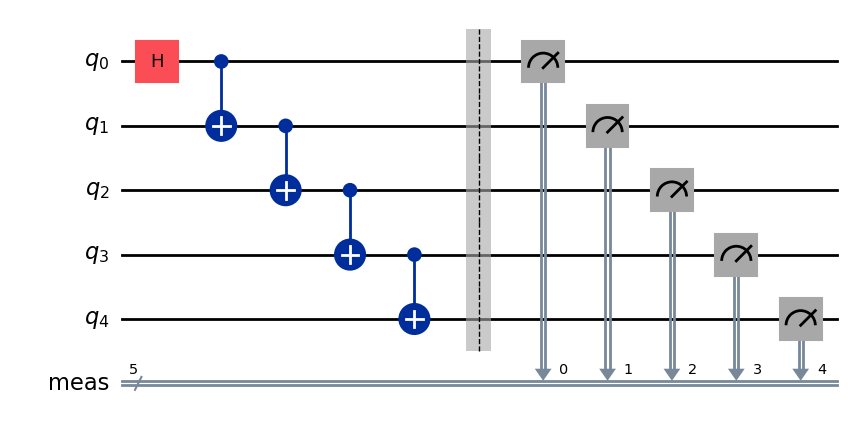

In [137]:
circuit = QuantumCircuit(5)
circuit.h(0)
circuit.cx(0,1)
circuit.cx(1,2)
circuit.cx(2,3)
circuit.cx(3,4)
circuit.measure_all()
circuit.draw('mpl')

Noiseless simulation

{'00000': 512, '11111': 512}


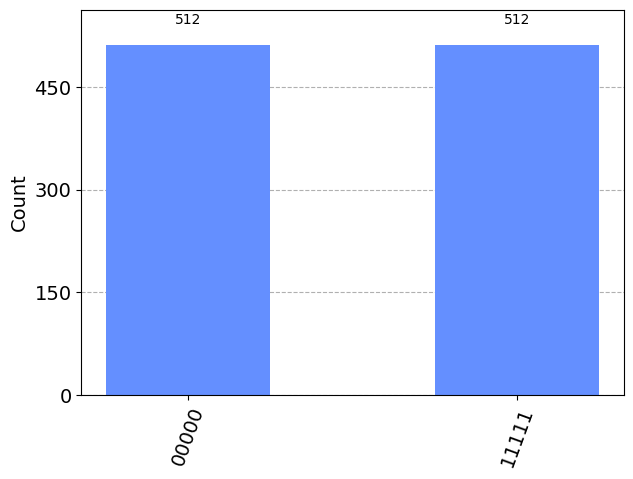

In [138]:
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
sim_ideal = AerSimulator()

# Execute and get counts
result = sim_ideal.run(transpile(circuit, sim_ideal),shots=1024).result()
counts = result.get_counts()
print(counts)
plot_histogram(counts)

Noisy simulation with depolarization noise of 5% for cx gates (2 qubit errors)

In [139]:
# Create an empty noise model
noise_model = NoiseModel()

# Add depolarizing error to all single qubit u1, u2, u3 gates
error = depolarizing_error(0.05, 2)
noise_model.add_all_qubit_quantum_error( error, ['cx'] )

# Print noise model info
print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx']
  Instructions with noise: ['cx']
  All-qubits errors: ['cx']


{'00101': 1, '10110': 1, '01000': 5, '00110': 1, '00100': 7, '00000': 461, '00010': 6, '01111': 6, '10111': 6, '11100': 11, '00001': 19, '10000': 6, '11011': 10, '11101': 6, '00011': 10, '00111': 11, '11111': 433, '11000': 11, '11110': 13}


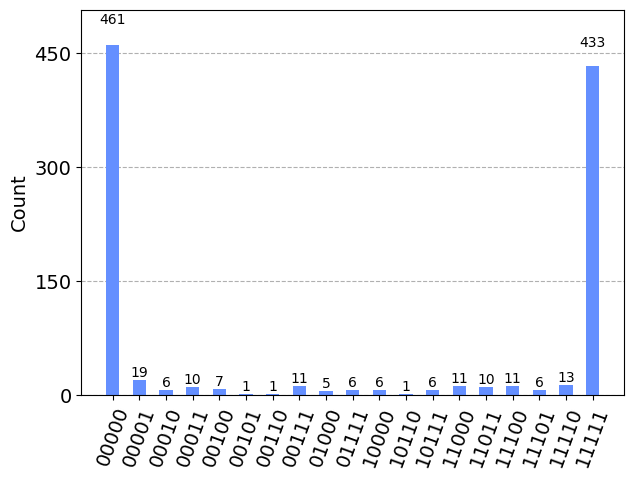

In [140]:
sim_noisy = AerSimulator(noise_model=noise_model)

# Execute and get counts
result = sim_noisy.run(transpile(circuit, sim_noisy),shots=1024).result()
counts = result.get_counts(0)
print(counts)
plot_histogram(counts)

{'00101': 0.0009765625, '10110': 0.0009765625, '01000': 0.0048828125, '00110': 0.0009765625, '00100': 0.0068359375, '00000': 0.4501953125, '00010': 0.005859375, '01111': 0.005859375, '10111': 0.005859375, '11100': 0.0107421875, '00001': 0.0185546875, '10000': 0.005859375, '11011': 0.009765625, '11101': 0.005859375, '00011': 0.009765625, '00111': 0.0107421875, '11111': 0.4228515625, '11000': 0.0107421875, '11110': 0.0126953125}


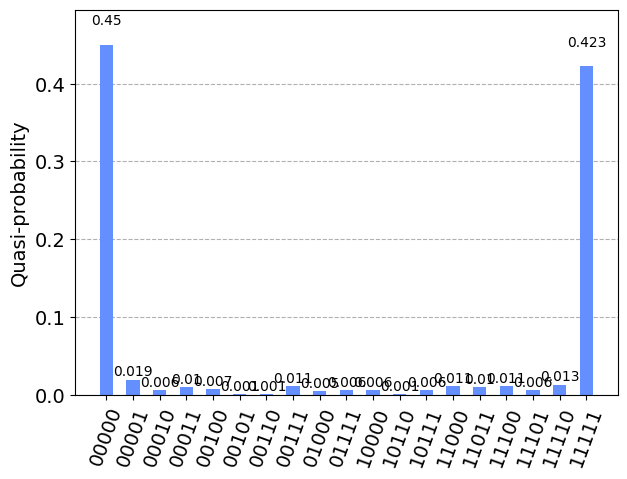

In [141]:
non_mitigated_hist = {}
for key,val in counts.items():
  non_mitigated_hist[key] = val/1024
print(non_mitigated_hist)
plot_histogram(non_mitigated_hist)

Performing ZNE in this case for all |1> case

In [142]:
from tqdm import tqdm
arr = []
full_out = []
noise_scale_factor = []
# We performing folding by repeating the circuit odd number of times
# to preseve the output.
for x in tqdm(range(1,16,2)):
  noise_scale_factor.append(x)
  circuit = QuantumCircuit(5)
  for i in range(x):
    circuit.h(0)
    circuit.cx(0,1)
    circuit.cx(1,2)
    circuit.cx(2,3)
    circuit.cx(3,4)
  circuit.measure_all()

  noise_model = NoiseModel()
  error = depolarizing_error(0.05, 2)
  noise_model.add_all_qubit_quantum_error( error, ['cx'] )

  sim_noisy = AerSimulator(noise_model=noise_model)

  # Execute and get counts
  result = sim_noisy.run(transpile(circuit, sim_noisy),shots=1024).result()
  counts = result.get_counts()
  full_out.append(counts)
  arr.append(counts.get('11111')/1024)


x = np.array(noise_scale_factor)
y = np.array(arr)

for i in range(1,6):
  p = np.polyfit(x,y,deg=i)
  x_new = np.array([0])
  y_new = np.polyval(p,x_new)
  print("degree:",str(i),"-",str(y_new))

100%|██████████| 8/8 [00:00<00:00, 14.27it/s]

degree: 1 - [0.23389834]
degree: 2 - [0.41711426]
degree: 3 - [0.57944558]
degree: 4 - [0.72300785]
degree: 5 - [0.77250669]


Plotting out curve fitting for all various degree polynomial and selecting the optimum one (not overfitting).

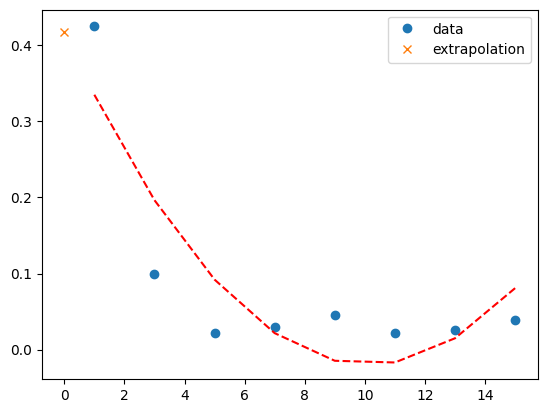

In [143]:
p = np.polyfit(x,y,deg=2)
x_new = np.array([0])
y_new = np.polyval(p,x_new)
curve_y = []
for i in range(len(x)):
  curve_y.append(np.polyval(p,x[i]))

plt.plot(x,y, 'o', label='data')
plt.plot(x_new, y_new, 'x', label='extrapolation')
plt.plot(x,curve_y,'--',color='red')
plt.legend()
plt.show()

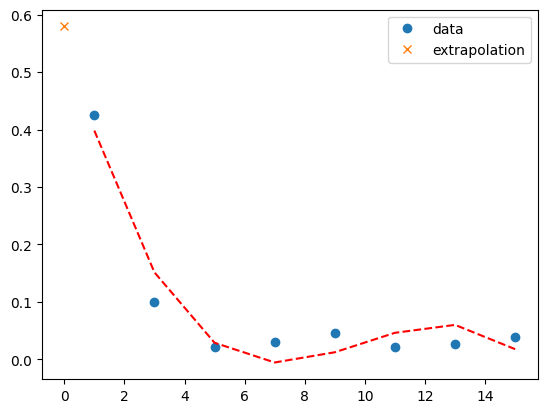

In [144]:
p = np.polyfit(x,y,deg=3)
x_new = np.array([0])
y_new = np.polyval(p,x_new)
curve_y = []
for i in range(len(x)):
  curve_y.append(np.polyval(p,x[i]))

plt.plot(x,y, 'o', label='data')
plt.plot(x_new, y_new, 'x', label='extrapolation')
plt.plot(x,curve_y,'--',color='red')
plt.legend()
plt.show()

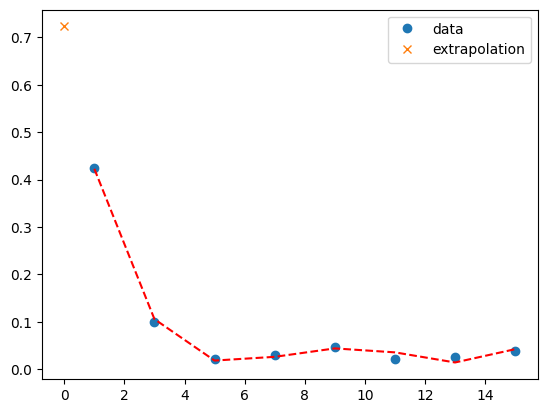

In [145]:
p = np.polyfit(x,y,deg=4)
x_new = np.array([0])
y_new = np.polyval(p,x_new)
curve_y = []
for i in range(len(x)):
  curve_y.append(np.polyval(p,x[i]))

plt.plot(x,y, 'o', label='data')
plt.plot(x_new, y_new, 'x', label='extrapolation')
plt.plot(x,curve_y,'--',color='red')
plt.legend()
plt.show()

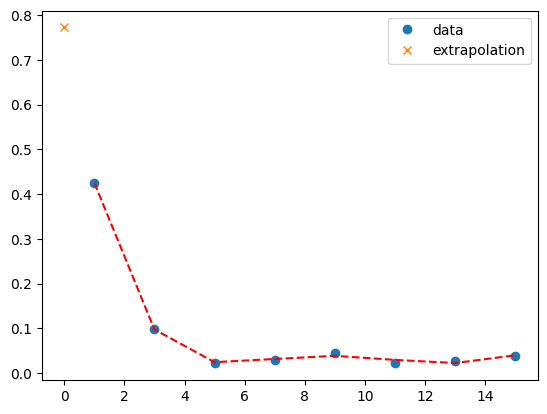

In [146]:
p = np.polyfit(x,y,deg=5)
x_new = np.array([0])
y_new = np.polyval(p,x_new)
curve_y = []
for i in range(len(x)):
  curve_y.append(np.polyval(p,x[i]))

plt.plot(x,y, 'o', label='data')
plt.plot(x_new, y_new, 'x', label='extrapolation')
plt.plot(x,curve_y,'--',color='red')
plt.legend()
plt.show()

From the plots degree 2 and 3 does not overfit and so we test with degree 2 to get all values of probabilities.

In [147]:
values = ['00000','00001','00010','00011','00100','00101','00110','00111','01000','01001','01010','01011','01100','01101','01110','01111','10000','10001','10010','10011','10100','10101','10110','10111','11000','11001','11010','11011','11100','11101','11110','11111']

In [148]:
# We get the counts of all probabilites, perform extrapolation with degree 2 and get the plot of noiseless value for the circuit

prob_values_mitigated = []

for i in range(len(values)):
  x_arr = []
  y_arr = []
  for u in range(1,16,2):
    x_arr.append(u)

  for j in range(len(full_out)):
    y_arr.append(full_out[j].get(values[i],0)/1024)

  x = np.array(x_arr)
  y = np.array(y_arr)

  p = np.polyfit(x,y,deg=2)
  x_new = np.array([0])
  y_new = np.polyval(p,x_new)
  prob_values_mitigated.append(y_new)

prob_values_mitigated = np.array(prob_values_mitigated)
print(prob_values_mitigated)

[[ 4.32669503e-01]
 [ 2.06240699e-02]
 [ 6.25900995e-03]
 [ 6.74438477e-03]
 [-3.55893090e-03]
 [-4.41196987e-03]
 [ 2.85063244e-02]
 [ 8.27752976e-03]
 [-1.63922991e-02]
 [-1.21372768e-02]
 [ 3.15987723e-02]
 [-6.60923549e-03]
 [ 3.10610817e-02]
 [-3.12151228e-03]
 [-4.47300502e-03]
 [-4.10679408e-03]
 [-1.20660691e-02]
 [-7.34165737e-03]
 [-2.57219587e-04]
 [ 2.90236700e-02]
 [-3.25956799e-03]
 [ 2.14974540e-02]
 [-3.06047712e-03]
 [-5.90006510e-03]
 [-3.74784924e-03]
 [ 3.04797945e-02]
 [-3.53567941e-03]
 [-2.70298549e-03]
 [ 1.25790551e-02]
 [ 5.99597749e-03]
 [ 1.42517090e-02]
 [ 4.17114258e-01]]


In [149]:
mitigated_hist = {}
for i in range(len(values)):
  mitigated_hist[values[i]] = prob_values_mitigated[i].item()
print(mitigated_hist)

{'00000': 0.4326695033482144, '00001': 0.020624069940476202, '00010': 0.006259009951636904, '00011': 0.006744384765625003, '00100': -0.00355893089657739, '00101': -0.004411969866071426, '00110': 0.028506324404761918, '00111': 0.008277529761904765, '01000': -0.016392299107142835, '01001': -0.012137276785714246, '01010': 0.03159877232142856, '01011': -0.00660923549107143, '01100': 0.031061081659226226, '01101': -0.0031215122767857184, '01110': -0.004473005022321442, '01111': -0.004106794084821429, '10000': -0.012066069103422618, '10001': -0.007341657366071406, '10010': -0.0002572195870535763, '10011': 0.029023670014880952, '10100': -0.0032595679873511896, '10101': 0.02149745396205356, '10110': -0.0030604771205357127, '10111': -0.005900065104166662, '11000': -0.003747849237351174, '11001': 0.03047979445684526, '11010': -0.0035356794084821326, '11011': -0.0027029854910714376, '11100': 0.012579055059523829, '11101': 0.005995977492559528, '11110': 0.014251708984375014, '11111': 0.41711425781

Plotting out the error mitigated histogram using polynomial of degree 2

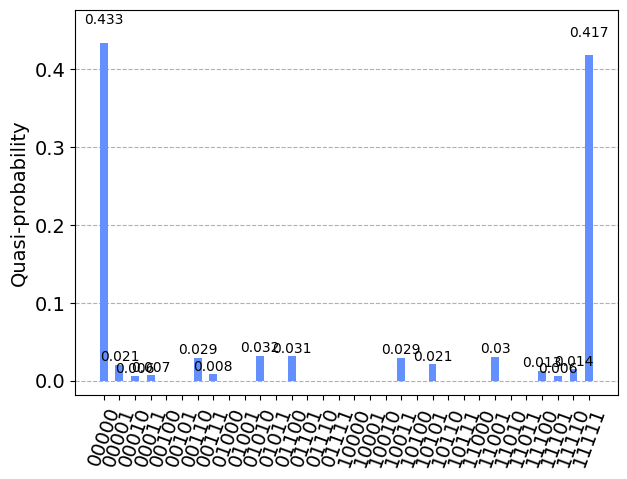

In [150]:
plot_histogram(mitigated_hist)